# Hyalophane analyses

## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set up to find custom python package
import os
import sys
import numpy as np
sys.path.insert(1, ".")
sys.path.insert(1, "..")

np.random.seed(42)

In [3]:
from src import readfiles, wdscan, correct_quant, calczaf, helper_funs
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pyrolite.geochem

from nb_helper_funs import compile_n_summary

2025-02-01 20:59:18,506 pyrolite.util.plot.helpers - WARNING: scikit-learn not installed


In [4]:
import pyrolite

# Major/trace elements other than N

In [5]:
hyal_majors_raw = pd.read_csv("../data/raw/hyalophane_StA/hyalophane_majors/20211110_hyalophane_all.txt",
                header=1, index_col=False)[:5]

mass_pct_cols = [col for col in hyal_majors_raw.columns if "(Mass%)" in col]
hyal_majors = hyal_majors_raw.loc[:, mass_pct_cols].rename(columns={col: col.replace("(Mass%)", "") for col in mass_pct_cols})
hyal_majors

c:\Users\Eleanor\miniconda3\envs\n_epma_analysis\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,SiO2,Al2O3,SrO,Fe2O3,K2O,BaO,Na2O,Total
0,49.01,22.36,0.4050,0.0156,6.18,20.40,1.45,99.8206
1,48.92,22.43,0.3933,0.0335,6.13,20.73,1.52,100.1568
2,48.79,22.50,0.4051,0.0128,6.18,20.63,1.48,99.9979
3,48.87,22.37,0.4041,0.0314,6.17,20.63,1.55,100.0255
4,48.94,22.54,0.4088,0.0092,6.09,20.54,1.59,100.1180


In [6]:
hyal_majors_raw[[col for col in hyal_majors_raw.columns if "(D.L.)" in col]]

,Si(D.L.),Al(D.L.),Sr(D.L.),Fe(D.L.),K(D.L.),Ba(D.L.),Na(D.L.)
0,136.0,76.0,151.0,92.0,42.0,145.0,73.0
1,135.0,76.0,147.0,89.0,42.0,144.0,76.0
2,137.0,73.0,149.0,92.0,41.0,144.0,78.0
3,137.0,76.0,141.0,91.0,41.0,144.0,75.0
4,136.0,75.0,157.0,93.0,42.0,144.0,72.0


In [7]:
hyal_majors_element = hyal_majors[["SiO2", "Al2O3", "SrO", "Fe2O3", "K2O", "BaO", "Na2O"]].pyrochem.convert_chemistry(
    to=["Si", "Al", "Sr", "Fe", "K", "Ba", "Na"]
)

hyal_majors_element["O"] = hyal_majors["Total"] - (hyal_majors_element.sum(axis=1))

hyal_majors_element["Total"] = hyal_majors_element.sum(axis=1)

In [8]:
hyal_majors_summary = pd.concat([hyal_majors_element.T.mean(axis=1), hyal_majors_element.T.std(axis=1)], axis=1)
hyal_majors_summary.columns = ["wt% mean", "stdev"]

In [27]:
hyal_majors_summary.round(2).to_csv("../data/processed/hyalophane_StA/hyalophane_majors_summary.csv")
hyal_majors_summary

,wt% mean,stdev
Si,22.860372,0.038347
Al,11.876386,0.041841
Sr,0.340994,0.004949
Fe,0.014338,0.007810
K,5.105409,0.032683
Ba,18.437879,0.110895
Na,1.126140,0.041105
O,40.262242,0.042569
Total,100.023760,0.130888


## Hyalophane
* Analysed at St Andrews
* Using GaN standard

### WD scan - visualise & fit

Saved figure for hyalophane


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'hyalophane'}, xlabel='L (mm)', ylabel='cps/nA'>)

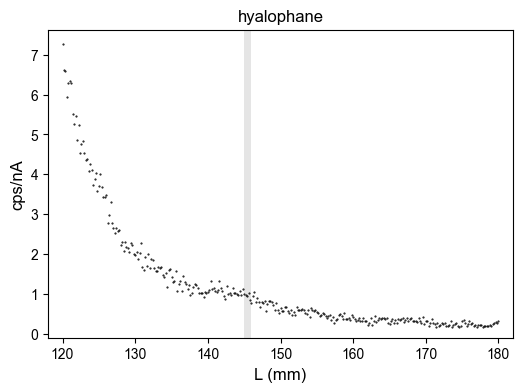

In [9]:
# ------#### INPUT #### -----------------------------
# Where is the data stored?
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/albite_22122021_0006_QLW/Pos_0001/')
# What's the sample name?
sample = 'hyalophane'
# Option to add peak position markers to plot:
pk_pos_markers =  [146.6] #
# ---------------------------------------------------
# Read in the data
comments, data = readfiles.import_jeol_wdscans(
    subfolder=Path("../data/raw/hyalophane_StA/wd_scans/hyalophane_22122021_0010_QLW/Pos_0002"),
    comment_line_num=80
)

# Plot the data without fitting
wdscan.plot_wdscan(comments, data, save_to="../data/interim/hyalophane_StA/wd_scan.png")

Saved figure showing fit to hyalophane in folder "..\data\interim\hyalophane_StA\fits"
Saved fit parameters for hyalophane


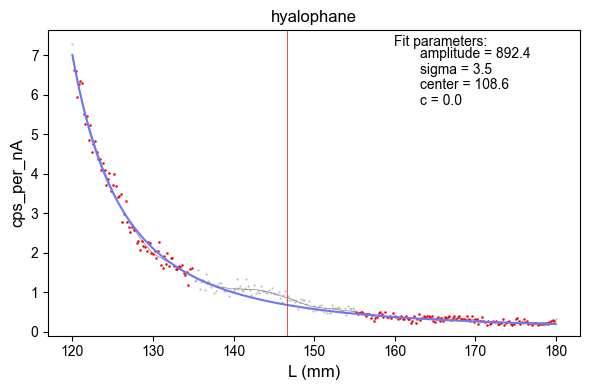

In [15]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,135], [155, 180]]

trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, pk_pos_markers, save_to=Path("../data/interim/hyalophane_StA/fits"))
par_dict = wdscan.write_fit_params(out, sample, save_to=Path("../data/interim/hyalophane_StA/fits/"))

### Quant analysis

In [16]:
samples = ['hyalophane_GaNcalib', 'hyalophane_BNcalib'] # List of samples in this dataset
sample_folders = [Path('../data/raw/hyalophane_StA/hyalophane_using_GaN_standard/'),
                  Path('../data/raw/hyalophane_StA/hyalophane_using_BN_standard/')] # List of folders corresponding to the samples
category = 'hyalophane' # Category of this dataset (e.g. "glasses")

wd_scan = Path('../data/interim/hyalophane_StA/fits/key_params_hyalophane.txt') # Path to wd scan fit parameters
std_dbase_info_file = Path('data/_dictionaries/standards.csv')

In [17]:
apf_file = Path('../data/_dictionaries/apf_values.csv')
apf_df = pd.read_csv(apf_file, header=0, index_col=0,
                    squeeze=True)
apf_df.T["hyalophane"]


apf       0.84
apf_sd    0.02
Name: hyalophane, dtype: float64

In [18]:
apf_file = Path('../data/_dictionaries/apf_values_relative_to_BN.csv')
apf_df = pd.read_csv(apf_file, header=0, index_col=0,
                    squeeze=True)
apf_df.T["hyalophane"]

apf       0.95
apf_sd    0.02
Name: hyalophane, dtype: float64

In [19]:
datalist = readfiles.find_files_and_folders(
                samples, sample_folders,
                apf_file=None,
                # apf_file=Path('../data/_dictionaries/apf_values.csv'), #<- Can put None in here
                wd_scan=wd_scan
                )

# add the apf values separately because these come from different files for the 
# different calibrations

apf_rel_GaN = pd.read_csv(Path('../data/_dictionaries/apf_values.csv'))

datalist["apf"] = [0.84] * 5 + [0.95] * 5
datalist["apf_sd"] = [0.02] * 5 + [0.02] * 5

datalist

Comments found: ['hyalophane_50nA_20um_GaNcalibr_5', 'hyalophane_50nA_20um_GaNcalibr_6', 'hyalophane_50nA_20um_GaNcalibr_7', 'hyalophane_50nA_20um_GaNcalibr_8', 'hyalophane_50nA_20um_GaNcalibr_9']
Comments found: ['hyalophane_50nA_20um_BNcalibr_1', 'hyalophane_50nA_20um_BNcalibr_2', 'hyalophane_50nA_20um_BNcalibr_3', 'hyalophane_50nA_20um_BNcalibr_4', 'hyalophane_50nA_20um_BNcalibr_5']


,folder,comment,sample,paramfile,apf,apf_sd
0,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_5,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.84,0.02
1,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_6,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.84,0.02
2,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_7,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.84,0.02
3,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_8,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.84,0.02
4,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_9,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.84,0.02
5,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_1,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.95,0.02
6,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_2,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.95,0.02
7,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_3,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.95,0.02
8,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_4,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.95,0.02
9,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_5,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.95,0.02


In [20]:
myspot = [None] * len(datalist.folder)

for i in range(len(datalist.folder)):
    peak, bg, standard, info = readfiles.read_and_organise_data(
                                    datalist.loc[i,:].copy(),
                                    bgi=False,
                                    save=False)
    myspot[i] = correct_quant.Spot()
    myspot[i].add_data(info, bg, peak, standard)
    myspot[i].add_wd_scan_params_from_file(wd_scan)
    print('Read dataset:', i + 1, 'of', len(datalist), ':',
          myspot[i].info.comment)
    myspot[i].comprehensify_data()


 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 1 of 10 : hyalophane_50nA_20um_GaNcalibr_5

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 2 of 10 : hyalophane_50nA_20um_GaNcalibr_6

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 3 of 10 : hyalophane_50nA_20um_GaNcalibr_7

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 4 of 10 : hyalophane_50nA_20um_GaNcalibr_8

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 5 of 10 : hyalophane_50nA_20um_GaNcalibr_9

 loading path: ..\data\i

In [21]:
correct_quant.process_datasets(
    myspot, 
    datalist, 
    num_mc_sims=100, 
    path_out=Path("../data/processed/hyalophane_StA/background_corrections/")
    )


Processing dataset: 1 of 10 : hyalophane_50nA_20um_GaNcalibr_5
Correcting background
Saved bg correction figure for 2021-12-22_hyalophane_50nA_20um_GaNcalibr_5
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2021-12-22_hyalophane_50nA_20um_GaNcalibr_5
correct height/area ratio
original kraw: 0.00 ± 100.00%
corrected kraw: 1.40 ± 7.02%

Processing dataset: 2 of 10 : hyalophane_50nA_20um_GaNcalibr_6
Correcting background
Saved bg correction figure for 2021-12-22_hyalophane_50nA_20um_GaNcalibr_6
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2021-12-22_hyalophane_50nA_20um_GaNcalibr_6
correct height/area ratio
original kraw: 0.00 ± 100.00%
corrected kraw: 1.38 ± 6.50%

Processing dataset: 3 of 10 : hyalophane_50nA_20um_GaNcalibr_7
Correcting background
Saved bg

Make figure showing background correction and montecarlo simulation for hyalophane

Next cell has modified code from Spot.correct_bg and Spot.correct_bg_mc method to make a prettier figure

monte-carlo loop 0 of 100
monte-carlo loop 50 of 100


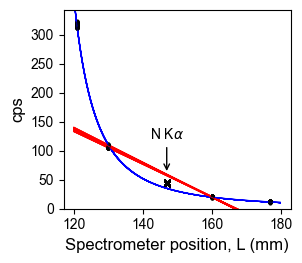

In [27]:
from scipy.stats import norm  # For monte carlo number generation
from src.correct_quant import compute_bg_positions, fit_quant_bg, lin_bg
import matplotlib.transforms as mtransforms
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = 10

def plot_background_correction(
        out, 
        pk_pos, 
        pk_cps,
        bg_pos, 
        bg_cps, 
        figure_axis=None,
        ):

    newx = np.arange(120.0, 180.0, 0.2)
    corrected_bg = out.eval(x=pk_pos)
    fitted = out.eval(x=newx)

    if figure_axis == None:
        plt.figure()
        ax = plt.axes()
    else:
        ax = figure_axis

    # Add the measured data
    plt.plot(bg_pos, bg_cps, 'ok', markersize=2)
    plt.plot(newx, fitted, '-b', linewidth=0.5, alpha=0.5)
    plt.plot(pk_pos, pk_cps, 'xk', linewidth=0.5)
    plt.plot(newx, lin_bg(newx, bg_cps[[0, 2]], bg_pos[[0, 2]]), '-r',
             linewidth=0.5)

    ylims = ax.get_ylim()
    plt.ylim(0, max(np.append(bg_cps, pk_cps)) +
             0.1 * max(np.append(bg_cps, pk_cps)))

    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    yrange = ylims[1] - ylims[0]
    xrange = xlims[1] - xlims[0]

    plt.xlabel('Spectrometer position, L (mm)')
    plt.ylabel('cps')

    return xlims, ylims



# Select spot of interest to use
spot = myspot[5]

fig, ax = plt.subplots(figsize=(8*0.39, 7*0.39))

# === Monte Carlo background correction =====================================

num_mc_sims = 100

idx = spot.idx_N[0]
idx_dupl = spot.idx_N[1]

# Create an array with rows being a mc-simulation of the peak cps
pk_cps_raw = norm.rvs(loc=spot.peak.raw_cps[idx],
                        scale=spot.peak.stdev_raw_cps[idx],
                        size=num_mc_sims, random_state=None)

# Get background positions based on relative position from peak
bg_pos = compute_bg_positions(spot)

# Get background cps values and stdevs
lwr_bg_cps = np.array(spot.bg.lwr_cps[idx:idx_dupl + 1])
upr_bg_cps = np.array(spot.bg.upr_cps[idx:idx_dupl + 1])
bg_cps_means = np.concatenate((lwr_bg_cps, upr_bg_cps), axis=0)

lwr_bg_stdev = np.array(spot.bg.stdev_lwr[idx:idx_dupl + 1])
upr_bg_stdev = np.array(spot.bg.stdev_upr[idx:idx_dupl + 1])
bg_cps_stdev = np.concatenate((lwr_bg_stdev, upr_bg_stdev), axis=0)

# Create a matrix with rows being mc-simulations of the background
bg_cps = np.empty(shape=(num_mc_sims, 4))

for i in range(4):
    bg_cps[:, i] = norm.rvs(loc=bg_cps_means[i],
                            scale=bg_cps_stdev[i],
                            size=num_mc_sims, random_state=None)

pk_cps_net_corrected = np.empty(shape=(num_mc_sims, 1))
bg_cps_corrected = np.empty(shape=(num_mc_sims, 1))

# Perform the background fits and plot a figure at the same time
fit_params_mc = [None] * num_mc_sims

for i in range(num_mc_sims):
    # Fit the background according to its shape

    # Print a loop counter
    if i % 50 == 0: # If i is divisible by 50
        print('monte-carlo loop {} of {}'.format(i, num_mc_sims))

    modelout = fit_quant_bg(bg_pos, bg_cps[i, :], spot.wd_scan_params)

    fit_params_mc[i] = [modelout.params['amplitude'].value,
                        modelout.params['c'].value]

    # Find the corrected background cps
    bg_cps_corrected[i] = modelout.eval(x=spot.peak.pos[idx])
    pk_cps_net_corrected[i] = pk_cps_raw[i] - bg_cps_corrected[i]

    # Add this to the figure
    xlims, ylims = plot_background_correction(
        modelout, spot.peak.pos[idx], pk_cps_raw[i], bg_pos,
        bg_cps[i, :], figure_axis=ax)

mean_from_mc = [np.mean(pk_cps_net_corrected), np.mean(bg_cps_corrected)]
stdev_pcnt_from_mc = [np.std(pk_cps_net_corrected) * 100 / mean_from_mc[0],
                        np.std(bg_cps_corrected) * 100 / mean_from_mc[1]]

ax.annotate(
    text=r"N K$\alpha$",
    xy=(146.893, 60),
    xytext=(146.893, 120),
    ha="center",
    arrowprops={"arrowstyle": "->"}
)

plt.tight_layout()
plt.savefig("../figures/fig_hyalophane_bg_correction_and_mc_simulation.png", dpi=600)
plt.savefig("../figures/for_submission/Figure_4.pdf", dpi=600)
plt.show()


In [37]:
summary_tables = correct_quant.write_summary_excel_tables(
    myspot, 
    "../data/processed/hyalophane_StA/kraw_summaries.xlsx"
    )

### Compile the typical k-ratio values with different levels of correction

In [38]:
typical_kratios = pd.DataFrame({
    "K-ratio": [
        summary_tables[0]["original.kraw_pcnt"].mean(),
        summary_tables[0]["montecarlo.kraw_pcnt"].mean(),
        summary_tables[0]["montecarlo.kraw_apf_pcnt"].mean()
    ],
    "Stdev % (relative)": [
        max(
            summary_tables[0]["original.kraw_stdev_pcnt"].mean(),
            summary_tables[0]["original.kraw_pcnt"].std()
            ),
        max(
            summary_tables[0]["montecarlo.kraw_stdev_pcnt"].mean(),
            summary_tables[0]["montecarlo.kraw_pcnt"].std()
            ),
        max(
            summary_tables[0]["montecarlo.kraw_stdev_apf_pcnt"].mean(),
            summary_tables[0]["montecarlo.kraw_apf_pcnt"].std()
            )
    ]
}, index = [
    "Original K-ratio (%)", 
    "Bg-corrected K-ratio (%)", 
    "Bg- and APF-corrected K-ratio (%)"
    ]
)

typical_kratios.insert(
    1, 
    column="Stdev (absolute)", 
    value = typical_kratios["K-ratio"] * typical_kratios["Stdev % (relative)"] / 100
    )

typical_kratios

,K-ratio,Stdev (absolute),Stdev % (relative)
Original K-ratio (%),0.000,0.000000,100.000
Bg-corrected K-ratio (%),0.761,0.056892,7.476
Bg- and APF-corrected K-ratio (%),0.881,0.068850,7.815


## Write calczaf file

In [39]:
samples = ['hyalophane_GaNcalib', 'hyalophane_BNcalib'] # List of samples in this dataset
category = 'hyalophane'
subfolder = Path('../data/processed/hyalophane_StA/calczaf_files/')

write_detection_limit_calczaf_files = True
detlim_subfolder = Path('../data/processed/hyalophane_StA/calczaf_files/detlim/')

# note: in the subfolder there must be a file specifying valence.
# this can be copied from the _dictionaries folder.
valence_dict = readfiles.read_valence_file(subfolder, pattern='valence*')
standard_database_dict = pd.read_csv(
    '../data/_dictionaries/standards.csv',
     index_col=0, 
     header=None, 
     squeeze=True).to_dict()

standard_database_dict

{'Sanidine': 3000,
 'Diopside': 3001,
 '08_Pollucite': 3002,
 'Albite': 3003,
 'GaN': 608,
 '22_Mo': 542,
 '09_Vanadium_Wire_Alfa': 523,
 'BN': 604}

In [40]:
# Make a dictionary
sampledata = [None]*len(samples)
for i, sample in enumerate(samples):
    sampledata[i] = [spot for i, spot in enumerate(myspot) if sample == spot.info['sample']]

sampledata = dict(zip(samples,sampledata))

In [41]:
hyal_literature_vals = pd.Series(dict(
    {"Si": 23.25,
     "Al": 11.65,
     "K":  5.68,
     "Na": 1.11,
     "Ba": 17.42,
     "Sr": 0.29}
))
hyal_literature_vals


# Or use actual analyses from StA

hyal_element_vals = hyal_majors_summary.loc[["Si", "Al", "Sr", "Fe", "K", "Ba", "Na"], "wt% mean"]

In [30]:
# For multiple different methods of processing the data, add a description
run_descriptor = ['_1_base', '_2_bg', '_3_bg_apf']  
# Leave as a list of an empty string if not using: e.g. run_descriptor = ['']

for i in range(len(samples)):

    # Here we pass in these arguments as a dictionary - this is useful in order
    # to reuse the arguments for the detection limit function. But you can
    # alternatively pass in each argument just by defining it in the function
    # as normal (see glasses example).

    args = {
              'elementByDifference' : None # string element symbol
            , 'elementByStoichToStoichOxygen' : None # string element symbol
            , 'stoichOxygenRatio' : 0
            # for hyalophane there is H
            # that can be defined stoichiometrically relative to N:
            , 'elementByStoichToOtherElement' : 'h'
            , 'OtherElement' : 'n'
            , 'stoichElementRatio' : 4

            , 'correct_bg' : False
            , 'correct_apf' : False

            # Elements to omit from matrix correction
            # (e.g. if analysed but not actually present in sample)
            , 'remove_elements' : None

            , 'definedElements' : hyal_element_vals.index # list of element symbols to add
            , 'definedElementWts' : hyal_element_vals.values # list of known element wt% to add
            }
    
    # Make copies of args with different values
    args2 = args.copy()
    args2["correct_bg"] = True
    args2["correct_apf"] = False

    args3 = args2.copy()
    args3["correct_bg"] = True
    args3["correct_apf"] = True

    args_list = [args, args2, args3]

    for j in range(len(run_descriptor)):
        print("******************************************************")
        print(args_list[j]["correct_bg"], args_list[j]["correct_apf"])
        print("******************************************************")

        calczaf_path_out = subfolder / '{}{}.dat'.format(
                                            samples[i], run_descriptor[j])
        open(calczaf_path_out, 'w').close()  # Erase contents of file

        if write_detection_limit_calczaf_files:
            
            detlim_path_out = detlim_subfolder / '{}{}_detlim.dat'.format(
                                            samples[i], run_descriptor[j])
            open(detlim_path_out, 'w').close()  # Erase contents of file

        for spot in sampledata[samples[i]]:

            calczaf.write_calczaf_input(
                spot, calczaf_path_out, valence_dict, standard_database_dict,
                accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                **args_list[j]) # <- **args unpacks the args dictionary defined earlier
                # so that all those arguments are passed into the function
                # without the need to type them all out.

            if write_detection_limit_calczaf_files:
                if args_list[j]['correct_bg']:

                    detlim_spot = correct_quant.create_detection_limit_spot(spot)

                    calczaf.write_calczaf_input(
                        detlim_spot, detlim_path_out, valence_dict, 
                        standard_database_dict,
                        accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                        **args_list[j])
                    
                else:
                    print('\n\nWarning: Not writing detection limit file.' 
                            'Calculating detection limit does not make sense'
                            ' except on background-corrected data. Raw data files' 
                            ' contain an estimate of detection limit without bg'
                            ' correction.\n')
                    
    

******************************************************
False False
******************************************************
Wrote CALCZAF file for hyalophane_50nA_20um_GaNcalibr_5 to ..\data\processed\hyalophane_StA\calczaf_files\hyalophane_GaNcalib_1_base.dat



Wrote CALCZAF file for hyalophane_50nA_20um_GaNcalibr_6 to ..\data\processed\hyalophane_StA\calczaf_files\hyalophane_GaNcalib_1_base.dat



Wrote CALCZAF file for hyalophane_50nA_20um_GaNcalibr_7 to ..\data\processed\hyalophane_StA\calczaf_files\hyalophane_GaNcalib_1_base.dat



Wrote CALCZAF file for hyalophane_50nA_20um_GaNcalibr_8 to ..\data\processed\hyalophane_StA\calczaf_files\hyalophane_GaNcalib_1_base.dat



Wrote CALCZAF file for hyalophane_50nA_20um_GaNcalibr_9 to ..\data\processed\hyalophane_StA\calczaf_files\hyalophane_GaNcalib_1_base.dat



******************************************************
True False
******************************************************
Wrote CALCZAF file for hyalophane_50nA_20um_GaNcalibr_5 t

# Manual step - run through calczaf
* Using XPP matrix correction method
* Default MAC table (LINEMU)

## Calczaf results

In [42]:
folderpath = Path('../data/processed/hyalophane_StA/calczaf_files/')

helper_funs.check_calczaf_folder_exists(folderpath)
valence_file = sorted(folderpath.glob('valence*'))[0]

results = calczaf.process_calczaf_outputs(folderpath, valence_file)

# For detection limits

results_detlim = calczaf.process_calczaf_outputs(folderpath / 'detlim/', valence_file, detlim=True)

[                      0           1           2           3           4
wt% element                                                            
Si            22.860400   22.860400   22.860400   22.860400   22.860400
Al            11.876400   11.876400   11.876400   11.876400   11.876400
Fe             0.014338    0.014338    0.014338    0.014338    0.014338
K              5.105410    5.105410    5.105410    5.105410    5.105410
Na             1.126140    1.126140    1.126140    1.126140    1.126140
H              0.000000    0.000000    0.000000    0.000000    0.000000
N              0.000000    0.000000    0.000000    0.000000    0.000000
Sr             0.340994    0.340994    0.340994    0.340994    0.340994
Ba            18.437900   18.437900   18.437900   18.437900   18.437900
O             40.260800   40.260800   40.260800   40.260800   40.260800
TOTAL        100.022000  100.022000  100.022000  100.022000  100.022000, None, None, None, None, None]
[                      0        

In [45]:
wt_pct_summary_table = pd.concat(
    {k: v[["average", "stdev"]] for k, v in results["wtdata"].items()},
    axis=1
    ).round(2)

wt_pct_summary_table.to_csv("../data/processed/hyalophane_StA/wt_pct_summary.csv")

wt_pct_summary_table


hyalophane_BNcalib_1_base       hyalophane_BNcalib_2_bg       hyalophane_BNcalib_3_bg_apf       hyalophane_GaNcalib_1_base       hyalophane_GaNcalib_2_bg       hyalophane_GaNcalib_3_bg_apf      
                              average stdev                 average stdev                     average stdev                    average stdev                  average stdev                      average stdev
wt% element                                                                                                                                                                                                   
Si                              22.86   0.0                   22.86  0.00                       22.86  0.00                      22.86   0.0                    22.86  0.00                        22.86  0.00
Al                              11.88   0.0                   11.88  0.00                       11.88  0.00                      11.88   0.0                    11.88  0.00                        11.88  0.00
Fe                               0.01   0.0                    0.01  0.00                        0.01  0.00                       0.01   0.0                     0.01  0.00                         0.01  0.00
K                                5.11   0.0                    5.11  0.00                        5.11  0.00                       5.11   0.0                     5.11  0.00                         5.11  0.00
Na                               1.13   0.0                    1.13  0.00                        1.13  0.00                       1.13   0.0                     1.13  0.00                         1.13  0.00
H                                0.00   0.0                    0.05  0.00                        0.05  0.00                       0.00   0.0                     0.06  0.00                         0.07  0.00
N                                0.00   0.0                    0.16  0.02                        0.17  0.02                       0.00   0.0                     0.19  0.01                         0.23  0.01
Sr                               0.34   0.0                    0.34  0.00                        0.34  0.00                       0.34   0.0                     0.34  0.00                         0.34  0.00
Ba                              18.44   0.0                   18.44  0.00                       18.44  0.00                      18.44   0.0                    18.44  0.00                        18.44  0.00
O                               40.26   0.0                   40.35  0.01                       40.36  0.01                      40.26   0.0                    40.37  0.00                        40.39  0.01
TOTAL                          100.02   0.0                  100.32  0.03                      100.34  0.03                     100.02   0.0                   100.38  0.02                       100.45  0.02

### Compile a summary of nitrogen with stdevs on both individual and multiple measurements

In [33]:
suffix_list = ["1_base", "2_bg", "3_bg_apf"]

summary, details = compile_n_summary(
    suffix_list, results, results_detlim, sampledata, datalist, summary_tables, samples
)

summary


Sample: hyalophane_GaNcalib, suffix: 1_base


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_5,0.0,100.0,0.0,NaN,0.0196
1,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_6,0.0,100.0,0.0,NaN,0.0194
2,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_7,0.0,100.0,0.0,NaN,0.0197
3,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_8,0.0,100.0,0.0,NaN,0.0195
4,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_9,0.0,100.0,0.0,NaN,0.0194


Sample: hyalophane_BNcalib, suffix: 1_base


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_1,0.0,100.0,0.0,NaN,0.0240
1,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_2,0.0,100.0,0.0,NaN,0.0239
2,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_3,0.0,100.0,0.0,NaN,0.0241
3,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_4,0.0,100.0,0.0,NaN,0.0239
4,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_5,0.0,100.0,0.0,NaN,0.0239


Sample: hyalophane_GaNcalib, suffix: 2_bg


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_5,0.194416,6.60,0.012831,0.013771,0.0196
1,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_6,0.191109,6.05,0.011562,0.012870,0.0194
2,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_7,0.205440,7.14,0.014668,0.014226,0.0197
3,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_8,0.185257,7.70,0.014265,0.012900,0.0195
4,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_9,0.185556,6.80,0.012618,0.013417,0.0194


Sample: hyalophane_BNcalib, suffix: 2_bg


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_1,0.181486,6.61,0.011996,0.014811,0.0240
1,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_2,0.144743,9.55,0.013823,0.020086,0.0239
2,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_3,0.155167,9.44,0.014648,0.024498,0.0241
3,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_4,0.154982,7.42,0.011500,0.016984,0.0239
4,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_5,0.177782,7.45,0.013245,0.014292,0.0239


Sample: hyalophane_GaNcalib, suffix: 3_bg_apf


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_5,0.231378,7.02,0.016243,0.016394,0.0196
1,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_6,0.227444,6.50,0.014784,0.015321,0.0194
2,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_7,0.244494,7.53,0.018410,0.016936,0.0197
3,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_8,0.220481,8.06,0.017771,0.015356,0.0195
4,hyalophane_GaNcalib,hyalophane_50nA_20um_GaNcalibr_9,0.220838,7.20,0.015900,0.015973,0.0194


Sample: hyalophane_BNcalib, suffix: 3_bg_apf


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_1,0.191024,6.94,0.013257,0.015591,0.0240
1,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_2,0.152352,9.78,0.014900,0.021143,0.0239
2,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_3,0.163322,9.67,0.015793,0.025787,0.0241
3,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_4,0.163128,7.71,0.012577,0.017878,0.0239
4,hyalophane_BNcalib,hyalophane_50nA_20um_BNcalibr_5,0.187125,7.74,0.014483,0.015044,0.0239


1_base                                                                                                 2_bg                                                                                              3_bg_apf                                                                                      
                    N wt% (average) N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average)  N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average)  N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots)
sample                                                                                                                                                                                                                                                                                                                              
hyalophane_BNcalib              0.0      NaN         0.02396                            0.0                          0.0        0.162832  0.018134         0.02396                       0.013042                     0.015961        0.171390  0.019089         0.02396                       0.014202                     0.016799
hyalophane_GaNcalib             0.0      NaN         0.01952                            0.0                          0.0        0.192356  0.013437         0.01952                       0.013189                     0.008271        0.228927  0.015996         0.01952                       0.016622                     0.009840

In [34]:
summary.to_csv("../data/processed/hyalophane_StA/N_summary.csv")

### Investigate effect of blank correction

For comparison with albite below, check out the raw cps and the magnitude of the bg correction

In [35]:
bg_at_peak_pos = [s.montecarlo.loc[0, "bg_cps_mc_mean"] for s in myspot]
print("Bg cps at peak position: {:.1f}".format(np.mean(bg_at_peak_pos)))
print(
    "Stdev of multiple measurements of bg cps: {:.1f}".format(
    np.mean(np.std(bg_at_peak_pos))
    )
)
print(
    "Typical stdev on bg cps, "
    "computed using montecarlo approach: "
    "relative = {:.1f} %, absolute = {:.1f}".format(
    np.mean([s.montecarlo.loc[0, "bg_cps_mc_stdev_pcnt"] for s in myspot]),
    np.mean([s.montecarlo.loc[0, "bg_cps_mc_mean"] * s.montecarlo.loc[0, "bg_cps_mc_stdev_pcnt"]/100 for s in myspot])
    )
)


Bg cps at peak position: 35.0
Stdev of multiple measurements of bg cps: 0.2
Typical stdev on bg cps, computed using montecarlo approach: relative = 0.8 %, absolute = 0.3


In [36]:
raw_cps = [s.peak.loc[0, "raw_cps"] for s in myspot]

print(np.mean(raw_cps))
(np.std(raw_cps))

44.06833333333335


0.9715397287010206

# Albite wavelength scan

In [37]:
# ------#### INPUT #### -----------------------------
# Where is the data stored?
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/albite_22122021_0006_QLW/Pos_0001/')
# What's the sample name?
sample = 'albite'
# Option to add peak position markers to plot:
# e.g. pk_pos_markers = False (no markers)
#      pk_pos_markers = [145.839] (one marker)
#      pk_pos_markers = [145.84, 145.73] (two markers)
pk_pos_markers =  [145.839] #
# ---------------------------------------------------

Figure not saved


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': '1'}, xlabel='L (mm)', ylabel='cps/nA'>)

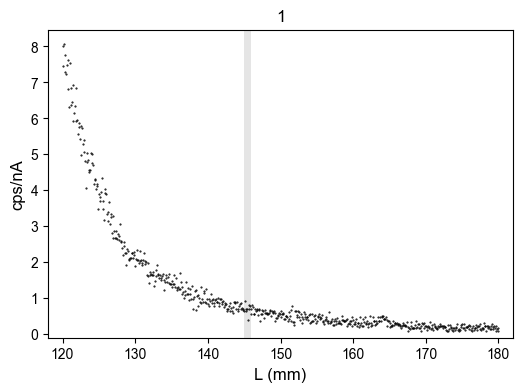

In [38]:
# Read in the data
comments, data = readfiles.import_jeol_wdscans(
    subfolder=scan_path)

# Plot the data without fitting
wdscan.plot_wdscan(comments, data, save_to=None)

Figure not saved
Parameters not saved


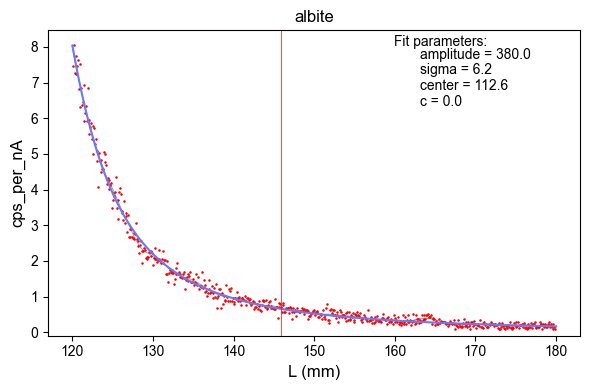

In [39]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,180]]

trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, pk_pos_markers, save_to=None)
par_dict = wdscan.write_fit_params(out, sample, save_to=None)

# Overlay hyalophane and albite wavelength scans

(118.0, 182.0)

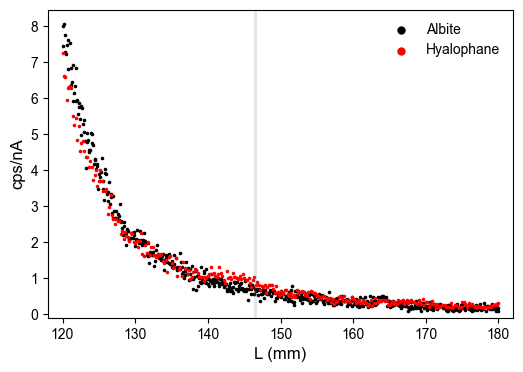

In [40]:
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/hyalophane_22122021_0010_QLW/Pos_0002/')
_, hyal_data = readfiles.import_jeol_wdscans(
    subfolder=scan_path)
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/albite_22122021_0006_QLW/Pos_0001/')
_, albite_data = readfiles.import_jeol_wdscans(
    subfolder=scan_path)

fig, ax = plt.subplots()

plt.scatter(albite_data.L, albite_data.cps_per_nA, marker='.', color='k', s=10, label="Albite")
plt.scatter(hyal_data.L, hyal_data.cps_per_nA, marker='.', color='r', s=10, label="Hyalophane")
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([100.0])

ylims = ax.get_ylim()
plt.ylim(-0.1, ylims[1])

pk_pos = [146.4, 146.8]

plt.fill_between([pk_pos[0], pk_pos[1], pk_pos[1], pk_pos[0]],
                    [-0.1, -0.1, ylims[1], ylims[1]], alpha=0.2, color='grey',
                    linewidth=0)

plt.xlabel('L (mm)')

plt.ylabel('cps/nA')
plt.xlim(118, 182)

# Albite quant analyses 

The point of an albite quant analysis was that if you measure on peak, you can use that value as a background for hyalophane. In principle...

Admittedly, albite doesn't have 17 wt% Ba though

In [41]:
samples = ['albite'] # List of samples in this dataset
sample_folders = [Path('../data/raw/hyalophane_StA/albite_quant/')] # List of folders corresponding to the samples
category = 'albite' # Category of this dataset (e.g. "glasses")

wd_scan = Path('data/interim/buddingtonite_ANU/fits/key_params_buddingtonite.txt') # Path to wd scan fit parameters
std_dbase_info_file = Path('data/_dictionaries/standards.csv')

In [42]:
datalist = readfiles.find_files_and_folders(
                samples, sample_folders,
                # apf_file=Path('data/_dictionaries/apf_values.csv'), #<- Can put None in here
                # wd_scan=wd_scan
                )

datalist

Comments found: ['albite_1', 'albite_2', 'albite_3', 'albite_4', 'albite_5']


,folder,comment,sample,paramfile,apf,apf_sd
0,..\data\raw\hyalophane_StA\albite_quant\Pos_0001,albite_1,albite,None,1,0.0
1,..\data\raw\hyalophane_StA\albite_quant\Pos_0002,albite_2,albite,None,1,0.0
2,..\data\raw\hyalophane_StA\albite_quant\Pos_0003,albite_3,albite,None,1,0.0
3,..\data\raw\hyalophane_StA\albite_quant\Pos_0004,albite_4,albite,None,1,0.0
4,..\data\raw\hyalophane_StA\albite_quant\Pos_0005,albite_5,albite,None,1,0.0


In [43]:
myspot = [None] * len(datalist.folder)

for i in range(len(datalist.folder)):
    peak, bg, standard, info = readfiles.read_and_organise_data(
                                    datalist.loc[i,:].copy(),
                                    bgi=False,
                                    save=False)
    myspot[i] = correct_quant.Spot()
    myspot[i].add_data(info, bg, peak, standard)
#   myspot[i].add_wd_scan_params_from_file(wd_scan)
    print('Read dataset:', i + 1, 'of', len(datalist), ':',
          myspot[i].info.comment)
    myspot[i].comprehensify_data()

Read dataset: 1 of 5 : albite_1
Read dataset: 2 of 5 : albite_2
Read dataset: 3 of 5 : albite_3
Read dataset: 4 of 5 : albite_4
Read dataset: 5 of 5 : albite_5


In [44]:
myspot[0].peak

,element,pos,net_cps,stdev_net_cps,dl_ppm,kraw_pcnt,time,raw_cps,kraw_stdev_pcnt,stdev_raw_cps
0,N,146.893,-22.6,100.0,236.0,0.0,120.0,33.116667,100.000162,0.525331
1,N,146.893,-162.5,100.0,439.0,0.0,1.0,30.046429,100.000162,5.481462


In [45]:
myspot[0].standard

,element,xray,crystal,pos,nA,net_cps,lwr_cps,upr_cps,standard,stdev_net_cps
0,N,Ka,LDE1L,146.893,50.54,2301.2,88.1,68.8,BN,0.18
1,N,Ka,LDE1L,146.893,50.54,2301.2,88.1,68.8,BN,0.18


Okay, so I only analysed nitrogen in this albite. 

I have five analyses for which all have raw cps values. 

So I can use these raw cps values (at the peak position) to correct the raw cps values for hyalophane as an alternative to the background correction method.

In [46]:
[s.peak.loc[0, "raw_cps"] for s in myspot]

[33.116666666666696,
 33.079999999999984,
 32.84666666666667,
 33.09333333333336,
 33.55666666666667]

That's the raw cps. 

In [47]:
print(np.mean([s.peak.loc[0, "raw_cps"] for s in myspot]))
(np.std([s.peak.loc[0, "raw_cps"] for s in myspot]))

33.13866666666668


0.23063776312169207

So the typical raw cps in those albite analyses was 33.1(2)

In contrast, from above, the typical background correction using the montecarlo background fitting approach on hyalophane directly was 35.0(3) (stdev on multiple measurements; this was larger than stdev on individual measurements).

So....
this means that on average if we used the albite as a background correction for hyalophane, we would gain two cps on the net background counts, given that these were about 10, this is an increase of about 20%

So we could expect the N concentrations to be about 20% larger if we did this.